In [3]:
from google.colab import drive
import zipfile
import os

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path to your zip file (update this path)
zip_path = '/content/drive/MyDrive/WildFaceDataset.zip'  # 👈 replace with actual path

# Extract the zip file
extract_path = '/content/facial_verification_data'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Files extracted to:", extract_path)
print("Subfolders:", os.listdir(extract_path))

✅ Files extracted to: /content/facial_verification_data
Subfolders: ['peopleDevTrain.csv', 'pairs.csv', 'matchpairsDevTest.csv', 'lfw-deepfunneled', 'matchpairsDevTrain.csv', 'lfw_allnames.csv', 'people.csv', 'peopleDevTest.csv', 'mismatchpairsDevTrain.csv', 'lfw_readme.csv', 'mismatchpairsDevTest.csv']


In [5]:
import pandas as pd


In [6]:
# df1=pd.read_csv("/content/facial_verification_data/matchpairsDevTrain.csv")

In [7]:
# df2=pd.read_csv("/content/facial_verification_data/mismatchpairsDevTrain.csv")

In [8]:
import pandas as pd
import os

# Base path where images are located
base_path = '/content/facial_verification_data/lfw-deepfunneled/lfw-deepfunneled'

# Load CSV files
match_df = pd.read_csv('/content/facial_verification_data/matchpairsDevTrain.csv')
mismatch_df = pd.read_csv('/content/facial_verification_data/mismatchpairsDevTrain.csv')

# Add label column
match_df['label'] = 1
mismatch_df['label'] = 0

# For matched pairs (same person)
match_df['img1_path'] = match_df.apply(
    lambda row: os.path.join(base_path, row['name'], f"{row['name']}_{int(row['imagenum1']):04d}.jpg"), axis=1)
match_df['img2_path'] = match_df.apply(
    lambda row: os.path.join(base_path, row['name'], f"{row['name']}_{int(row['imagenum2']):04d}.jpg"), axis=1)

# For mismatched pairs (different people)
mismatch_df['img1_path'] = mismatch_df.apply(
    lambda row: os.path.join(base_path, row['name'], f"{row['name']}_{int(row['imagenum1']):04d}.jpg"), axis=1)
mismatch_df['img2_path'] = mismatch_df.apply(
    lambda row: os.path.join(base_path, row['name.1'], f"{row['name.1']}_{int(row['imagenum2']):04d}.jpg"), axis=1)

# Keep only necessary columns
match_df = match_df[['img1_path', 'img2_path', 'label']]
mismatch_df = mismatch_df[['img1_path', 'img2_path', 'label']]

# Concatenate
train_pairs = pd.concat([match_df, mismatch_df], ignore_index=True)

# Shuffle
train_pairs = train_pairs.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Training dataset created successfully!")
print("Total pairs:", len(train_pairs))
print(train_pairs.head(5))


✅ Training dataset created successfully!
Total pairs: 2200
                                           img1_path  \
0  /content/facial_verification_data/lfw-deepfunn...   
1  /content/facial_verification_data/lfw-deepfunn...   
2  /content/facial_verification_data/lfw-deepfunn...   
3  /content/facial_verification_data/lfw-deepfunn...   
4  /content/facial_verification_data/lfw-deepfunn...   

                                           img2_path  label  
0  /content/facial_verification_data/lfw-deepfunn...      0  
1  /content/facial_verification_data/lfw-deepfunn...      0  
2  /content/facial_verification_data/lfw-deepfunn...      0  
3  /content/facial_verification_data/lfw-deepfunn...      0  
4  /content/facial_verification_data/lfw-deepfunn...      0  


In [9]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch

class SiameseDataset(Dataset):
    def __init__(self, pairs_df, transform=None):
        self.pairs_df = pairs_df
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # scale to [-1, 1]
        ])

    def __len__(self):
        return len(self.pairs_df)

    def __getitem__(self, idx):
        row = self.pairs_df.iloc[idx]
        img1_path = row['img1_path']
        img2_path = row['img2_path']
        label = torch.tensor(row['label'], dtype=torch.float32)

        # Load images
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # Apply transforms
        img1 = self.transform(img1)
        img2 = self.transform(img2)

        return img1, img2, label


In [10]:
from torch.utils.data import DataLoader

# Create Dataset instance
train_dataset = SiameseDataset(train_pairs)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Check one batch
for batch in train_loader:
    img1, img2, label = batch
    print("Batch shapes:", img1.shape, img2.shape)
    print("Labels:", label[:10])
    break


Batch shapes: torch.Size([32, 3, 100, 100]) torch.Size([32, 3, 100, 100])
Labels: tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepSiameseCNN(nn.Module):
    def __init__(self):
        super(DeepSiameseCNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True)
        )

        # temporary dummy layer — we'll compute correct size below
        self.fc = None

    def forward_once(self, x):
        x = self.cnn(x)
        print("Feature map shape after CNN:", x.shape)  # 👈 debug
        return x


    def forward(self, input1, input2):
        out1 = self.forward_once(input1)
        out2 = self.forward_once(input2)
        return out1, out2


In [12]:
from torchvision.models import mobilenet_v2

class SiameseMobileNet(nn.Module):
    def __init__(self, embedding_dim=256):
        super().__init__()
        mobilenet = mobilenet_v2(pretrained=True)
        self.features = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, embedding_dim)

    def forward_once(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

    def forward(self, x1, x2):
        return self.forward_once(x1), self.forward_once(x2)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Feature extractor CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers for embedding
        self.fc = nn.Sequential(
            nn.Linear(256 * 10 * 10, 512),  # depends on image size
            nn.ReLU(inplace=True),
            nn.Linear(512, 128)  # embedding size = 128
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)  # flatten
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [14]:
model = SiameseNetwork()
img1, img2, _ = next(iter(train_loader))
out1, out2 = model(img1, img2)
print("Embedding shape:", out1.shape)


Embedding shape: torch.Size([32, 128])


In [15]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Euclidean distance
        dist = F.pairwise_distance(output1, output2)

        # invert labels: 1 → same, 0 → different
        label = 1 - label

        loss = torch.mean(
            (1 - label) * dist.pow(2) +  # same pairs
            label * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)  # different pairs
        )
        return loss


In [16]:
# # Test the loss
# criterion = ContrastiveLoss(margin=2.0)

# # Dummy embeddings
# out1 = torch.randn(8, 128)
# out2 = torch.randn(8, 128)
# labels = torch.randint(0, 2, (8,)).float()

# loss_val = criterion(out1, out2, labels)
# print("Test loss value:", loss_val.item())


In [17]:
import torch.optim as optim
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model, loss, and optimizer
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training settings
num_epochs = 30  # You can increase later (e.g., 25-50 for better convergence)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")

    for batch_idx, (img1, img2, label) in progress_bar:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        # Forward pass
        out1, out2 = model(img1, img2)
        loss = criterion(out1, out2, label)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm bar
        progress_bar.set_postfix({'Batch Loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}] - Average Loss: {epoch_loss:.4f}")

print("✅ Training complete!")


Using device: cuda


Epoch 1: 100%|██████████| 69/69 [00:11<00:00,  6.07it/s, Batch Loss=0.7296]


Epoch [1/30] - Average Loss: 0.9135


Epoch 2: 100%|██████████| 69/69 [00:09<00:00,  7.26it/s, Batch Loss=0.6399]


Epoch [2/30] - Average Loss: 0.6769


Epoch 3: 100%|██████████| 69/69 [00:10<00:00,  6.58it/s, Batch Loss=0.5290]


Epoch [3/30] - Average Loss: 0.5450


Epoch 4: 100%|██████████| 69/69 [00:11<00:00,  5.89it/s, Batch Loss=0.3140]


Epoch [4/30] - Average Loss: 0.4338


Epoch 5: 100%|██████████| 69/69 [00:10<00:00,  6.69it/s, Batch Loss=0.4070]


Epoch [5/30] - Average Loss: 0.3288


Epoch 6: 100%|██████████| 69/69 [00:09<00:00,  6.95it/s, Batch Loss=0.3804]


Epoch [6/30] - Average Loss: 0.2395


Epoch 7: 100%|██████████| 69/69 [00:09<00:00,  7.10it/s, Batch Loss=0.2570]


Epoch [7/30] - Average Loss: 0.1773


Epoch 8: 100%|██████████| 69/69 [00:10<00:00,  6.60it/s, Batch Loss=0.0911]


Epoch [8/30] - Average Loss: 0.1212


Epoch 9: 100%|██████████| 69/69 [00:10<00:00,  6.73it/s, Batch Loss=0.0994]


Epoch [9/30] - Average Loss: 0.0805


Epoch 10: 100%|██████████| 69/69 [00:10<00:00,  6.72it/s, Batch Loss=0.0560]


Epoch [10/30] - Average Loss: 0.0614


Epoch 11: 100%|██████████| 69/69 [00:09<00:00,  7.25it/s, Batch Loss=0.0808]


Epoch [11/30] - Average Loss: 0.0430


Epoch 12: 100%|██████████| 69/69 [00:10<00:00,  6.61it/s, Batch Loss=0.0262]


Epoch [12/30] - Average Loss: 0.0336


Epoch 13: 100%|██████████| 69/69 [00:10<00:00,  6.70it/s, Batch Loss=0.0321]


Epoch [13/30] - Average Loss: 0.0271


Epoch 14: 100%|██████████| 69/69 [00:10<00:00,  6.72it/s, Batch Loss=0.0329]


Epoch [14/30] - Average Loss: 0.0247


Epoch 15: 100%|██████████| 69/69 [00:09<00:00,  7.21it/s, Batch Loss=0.0227]


Epoch [15/30] - Average Loss: 0.0211


Epoch 16: 100%|██████████| 69/69 [00:10<00:00,  6.75it/s, Batch Loss=0.0257]


Epoch [16/30] - Average Loss: 0.0201


Epoch 17: 100%|██████████| 69/69 [00:10<00:00,  6.67it/s, Batch Loss=0.0114]


Epoch [17/30] - Average Loss: 0.0183


Epoch 18: 100%|██████████| 69/69 [00:10<00:00,  6.67it/s, Batch Loss=0.0161]


Epoch [18/30] - Average Loss: 0.0178


Epoch 19: 100%|██████████| 69/69 [00:09<00:00,  7.02it/s, Batch Loss=0.0161]


Epoch [19/30] - Average Loss: 0.0197


Epoch 20: 100%|██████████| 69/69 [00:09<00:00,  6.97it/s, Batch Loss=0.0213]


Epoch [20/30] - Average Loss: 0.0181


Epoch 21: 100%|██████████| 69/69 [00:10<00:00,  6.68it/s, Batch Loss=0.0210]


Epoch [21/30] - Average Loss: 0.0185


Epoch 22: 100%|██████████| 69/69 [00:10<00:00,  6.71it/s, Batch Loss=0.0218]


Epoch [22/30] - Average Loss: 0.0174


Epoch 23: 100%|██████████| 69/69 [00:10<00:00,  6.73it/s, Batch Loss=0.0097]


Epoch [23/30] - Average Loss: 0.0185


Epoch 24: 100%|██████████| 69/69 [00:09<00:00,  7.15it/s, Batch Loss=0.0127]


Epoch [24/30] - Average Loss: 0.0176


Epoch 25: 100%|██████████| 69/69 [00:10<00:00,  6.69it/s, Batch Loss=0.0121]


Epoch [25/30] - Average Loss: 0.0207


Epoch 26: 100%|██████████| 69/69 [00:10<00:00,  6.64it/s, Batch Loss=0.0155]


Epoch [26/30] - Average Loss: 0.0200


Epoch 27: 100%|██████████| 69/69 [00:10<00:00,  6.68it/s, Batch Loss=0.0260]


Epoch [27/30] - Average Loss: 0.0210


Epoch 28: 100%|██████████| 69/69 [00:09<00:00,  7.23it/s, Batch Loss=0.0141]


Epoch [28/30] - Average Loss: 0.0207


Epoch 29: 100%|██████████| 69/69 [00:10<00:00,  6.72it/s, Batch Loss=0.0182]


Epoch [29/30] - Average Loss: 0.0199


Epoch 30: 100%|██████████| 69/69 [00:10<00:00,  6.68it/s, Batch Loss=0.0144]

Epoch [30/30] - Average Loss: 0.0197
✅ Training complete!


In [19]:
model.eval()
with torch.no_grad():
    img1, img2, label = next(iter(test_loader))
    out1, out2 = model(img1.to(device), img2.to(device))
    dist = F.pairwise_distance(out1, out2)
    print("Mean distance (same):", dist[label==1].mean().item())
    print("Mean distance (diff):", dist[label==0].mean().item())


NameError: name 'test_loader' is not defined

#Testing

In [20]:
match_test = pd.read_csv('/content/facial_verification_data/matchpairsDevTest.csv')
mismatch_test = pd.read_csv('/content/facial_verification_data/mismatchpairsDevTest.csv')

# Add labels
match_test['label'] = 1
mismatch_test['label'] = 0

# Create image paths
match_test['img1_path'] = match_test.apply(
    lambda row: os.path.join(base_path, row['name'], f"{row['name']}_{int(row['imagenum1']):04d}.jpg"), axis=1)
match_test['img2_path'] = match_test.apply(
    lambda row: os.path.join(base_path, row['name'], f"{row['name']}_{int(row['imagenum2']):04d}.jpg"), axis=1)

mismatch_test['img1_path'] = mismatch_test.apply(
    lambda row: os.path.join(base_path, row['name'], f"{row['name']}_{int(row['imagenum1']):04d}.jpg"), axis=1)
mismatch_test['img2_path'] = mismatch_test.apply(
    lambda row: os.path.join(base_path, row['name.1'], f"{row['name.1']}_{int(row['imagenum2']):04d}.jpg"), axis=1)

# Combine and shuffle
test_pairs = pd.concat([match_test, mismatch_test], ignore_index=True)
test_pairs = test_pairs.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Test dataset created:", len(test_pairs))
print(test_pairs.head())


✅ Test dataset created: 1000
            name  imagenum1  imagenum2  label  \
0  Alex_Corretja          1          1      0   
1    Enrica_Fico          1          1      0   
2   Eric_Lindros          1          1      0   
3  Chris_Andrews          1          2      0   
4  Robbie_Fowler          1          2      1   

                                           img1_path  \
0  /content/facial_verification_data/lfw-deepfunn...   
1  /content/facial_verification_data/lfw-deepfunn...   
2  /content/facial_verification_data/lfw-deepfunn...   
3  /content/facial_verification_data/lfw-deepfunn...   
4  /content/facial_verification_data/lfw-deepfunn...   

                                           img2_path              name.1  
0  /content/facial_verification_data/lfw-deepfunn...       Newt_Gingrich  
1  /content/facial_verification_data/lfw-deepfunn...      Erwin_Abdullah  
2  /content/facial_verification_data/lfw-deepfunn...  Sterling_Hitchcock  
3  /content/facial_verification_data/lf

In [21]:
test_dataset = SiameseDataset(test_pairs)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
model.eval()
with torch.no_grad():
    img1, img2, label = next(iter(test_loader))
    out1, out2 = model(img1.to(device), img2.to(device))
    dist = F.pairwise_distance(out1, out2)
    print("Mean distance (same):", dist[label==1].mean().item())
    print("Mean distance (diff):", dist[label==0].mean().item())


Mean distance (same): 0.9818636178970337
Mean distance (diff): 1.3192579746246338


In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

model.eval()
distances = []
labels = []

with torch.no_grad():
    for img1, img2, label in tqdm(test_loader, desc="Evaluating"):
        img1, img2 = img1.to(device), img2.to(device)
        out1, out2 = model(img1, img2)

        # Euclidean distance
        euclidean_distance = F.pairwise_distance(out1, out2)
        distances.append(euclidean_distance.cpu().numpy())
        labels.append(label.numpy())

# Flatten arrays
distances = np.concatenate(distances)
labels = np.concatenate(labels)

# Normalize distances to [0,1]
distances = (distances - distances.min()) / (distances.max() - distances.min())


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  8.26it/s]


In [24]:
thresholds = np.linspace(0, 2, 200)  # widen range to cover your distances
best_acc, best_thresh = 0, 0

for t in thresholds:
    preds = (distances < t).astype(int)
    acc = accuracy_score(labels, preds)
    if acc > best_acc:
        best_acc, best_thresh = acc, t

print(f"✅ Best Threshold: {best_thresh:.3f} | Accuracy: {best_acc:.3f}")


✅ Best Threshold: 0.322 | Accuracy: 0.702


In [42]:
# plt.hist(distances[labels==1], bins=40, alpha=0.6, label='Same (label=1)')
# plt.hist(distances[labels==0], bins=40, alpha=0.6, label='Different (label=0)')
# plt.axvline(best_thresh, color='red', linestyle='--', label=f'Threshold={best_thresh:.2f}')
# plt.legend(); plt.xlabel('Euclidean Distance'); plt.ylabel('Count');
# plt.show()


In [26]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(labels, -distances)  # negative because smaller = more similar
print("ROC-AUC:", auc)


ROC-AUC: 0.7783479999999998


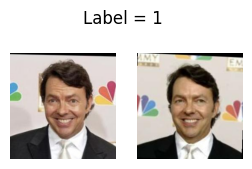

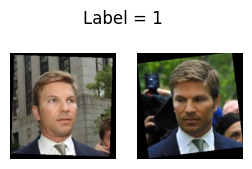

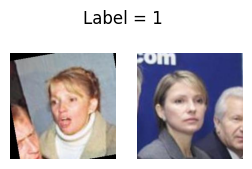

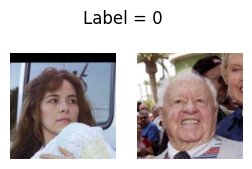

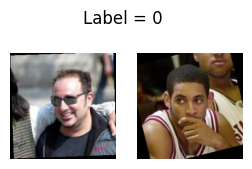

In [27]:
import matplotlib.pyplot as plt
import random, PIL.Image as Image
for _ in range(5):
    r = random.randint(0, len(train_pairs)-1)
    row = train_pairs.iloc[r]
    img1, img2 = Image.open(row.img1_path), Image.open(row.img2_path)
    plt.figure(figsize=(3,2))
    plt.subplot(1,2,1); plt.imshow(img1); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img2); plt.axis('off')
    plt.suptitle(f"Label = {row.label}")
    plt.show()


In [40]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

print("📸 Upload the first image (Photo 1 – Person A)")
uploaded1 = files.upload()
img1_path = list(uploaded1.keys())[0]

print("\n📸 Upload the second image (Photo 2 – Person B)")
uploaded2 = files.upload()
img2_path = list(uploaded2.keys())[0]

print(f"\n✅  Uploaded:\n 1️⃣ {img1_path}\n 2️⃣ {img2_path}")


📸 Upload the first image (Photo 1 – Person A)


Saving b.jpg to b (1).jpg

📸 Upload the second image (Photo 2 – Person B)


Saving c.jpg to c (3).jpg

✅  Uploaded:
 1️⃣ b (1).jpg
 2️⃣ c (3).jpg


In [29]:
!pip install facenet-pytorch
from facenet_pytorch import MTCNN
from PIL import Image

mtcnn = MTCNN(image_size=100, margin=10)  # same final size (100x100)

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    face = mtcnn(img)
    if face is None:
        print("⚠️ No face detected in:", image_path)
        return None
    return face  # returns a cropped, aligned torch tensor


In [30]:
from torchvision import transforms
transform = transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

def get_embedding(model, image_path):
    face_tensor = preprocess_image(image_path)
    if face_tensor is None:
        return None
    img = transform(face_tensor).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.forward_once(img)
        emb = F.normalize(emb, p=2, dim=1)
    return emb.cpu()


In [31]:
import torch
import torch.nn.functional as F
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# same transform used during training
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

from torchvision import transforms
transform = transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

def get_embedding(model, image_path):
    face_tensor = preprocess_image(image_path)
    if face_tensor is None:
        return None
    img = transform(face_tensor).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.forward_once(img)
        emb = F.normalize(emb, p=2, dim=1)
    return emb.cpu()

def verify_faces(model, img1_path, img2_path, threshold=0.23):
    emb1 = get_embedding(model, img1_path)
    emb2 = get_embedding(model, img2_path)
    dist = F.pairwise_distance(emb1, emb2).item()
    sim = max(0, 1 - dist)
    verdict = "✅  SAME PERSON" if dist < threshold else "❌  DIFFERENT PERSON"
    print(f"\nEuclidean Distance: {dist:.3f}")
    print(f"Similarity Score  : {sim:.3f}")
    print(f"Decision          : {verdict}")
    return dist, sim, verdict



Euclidean Distance: 0.143
Similarity Score  : 0.857
Decision          : ✅  SAME PERSON


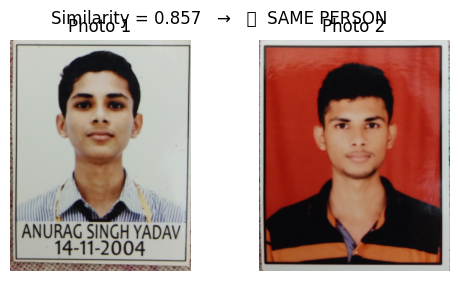

In [41]:
dist, sim, verdict = verify_faces(model, img1_path, img2_path)

# Display both photos
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(Image.open(img1_path)); ax[0].axis('off'); ax[0].set_title("Photo 1")
ax[1].imshow(Image.open(img2_path)); ax[1].axis('off'); ax[1].set_title("Photo 2")
plt.suptitle(f"Similarity = {sim:.3f}   →   {verdict}", fontsize=12)
plt.show()
